In [25]:
%load_ext autoreload
%autoreload 2
from clustering.herdingspikes import *
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
O = spikeclass('test_datasets/P38part_for_git_2.hdf5') # this loads a file that was saved by the class itself
#O = ImportInterpolated('/run/user/1000/gvfs/sftp:host=theia,user=s1474748/afs/inf.ed.ac.uk/user/s14/s1474748/scratch/mhennig/P38_06_Mar_14_light_stim/HdfFilesSpkD45/Retina02_LeftEye_Stim01_whitenoise100ms_SpkD45_v18.hdf5',shapesupto=22) #if reading a normal file

In [3]:
data = O.Locations()
threshold = 10
nbins = [40,40]
gthres = 10
hg,bx,by = np.histogram2d(data[0],data[1],nbins)
binspanx = (np.max(data[0])-np.min(data[0]))/nbins[0]*1.001
binspany = (np.max(data[1])-np.min(data[1]))/nbins[1]*1.001
nbx = ((data[0]-np.min(data[0]))//binspanx).astype(int)
nby = ((data[1]-np.min(data[1]))//binspany).astype(int)
ind = np.where(hg[nbx,nby]<=threshold)[0]
print "Based on "+str(len(ind))+" examples of bad shapes."
normalise = lambda X: X/np.max(np.abs(X),axis=0)
badshape = np.mean(normalise(O.Shapes()[:,ind]),axis=1)

fakeampl = np.max(np.abs(O.Shapes()),axis=0)
ind = np.where(fakeampl>gthres)[0]
print "Based on "+str(len(ind))+" examples of good shapes."
goodshape = np.mean(normalise(O.Shapes()[:,ind]),axis=1)

classifier = .5*(goodshape-badshape)

Based on 1205 examples of bad shapes.
Based on 939 examples of good shapes.


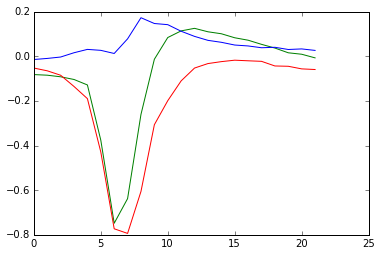

In [4]:
fig,ax=subplots()
ax.plot(goodshape,'g')
ax.plot(badshape,'r')
ax.plot(classifier)

Crop removed 0 clusters and 0 datapoints.
Starting sklearn PCA... done.


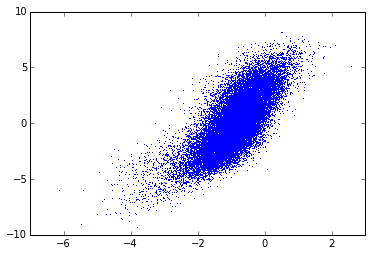

In [43]:
O.Crop(4.,7.,54.,58.)
score = np.dot(classifier,(O.Shapes())) #can be normalised or not!
scorePCA = O.ShapePCA(ncomp=1)[0]
plot(score,scorePCA,',')

In [17]:
score.shape

(30757,)

There is a good correlation between the first PC and the "score" obtained by bad and good examples, which is promising.

In [48]:
O.CombinedMeanShift(0.35,0.25)

Starting sklearn PCA... done.
Starting sklearn Mean Shift...  done.


FilterSmallClusters removed 0 clusters and 0 datapoints.


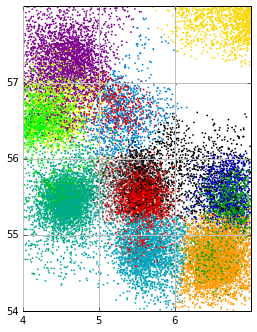

In [49]:
O.FilterSmallClusters(100)
O.PartPlot(4.,7.,54.,58.)

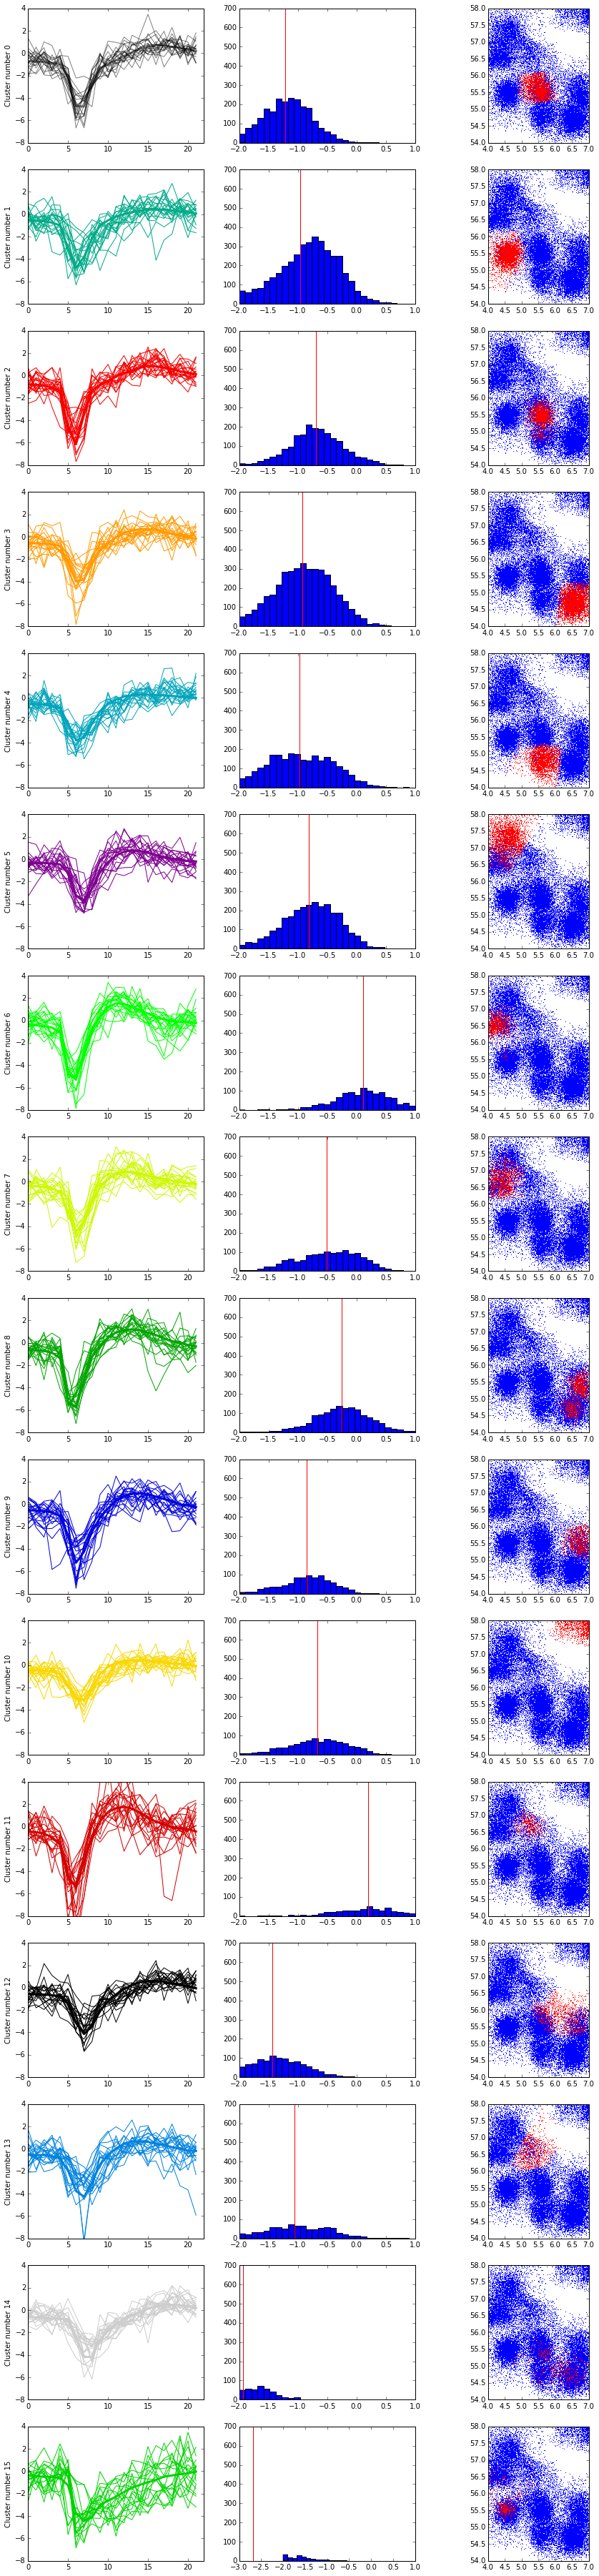

In [50]:
avgshapes = array(map(lambda cl: mean(O.Shapes()[:,O.ClusterID()==cl],axis=1),range(O.NClusters()))).T
clscore = np.dot(classifier,(avgshapes))


clusters = range(O.NClusters())
fig,ax=subplots(len(clusters),3,figsize=(15,4*len(clusters)))
for n,cluster in enumerate(clusters):
    ind = O.ClusterID()==cluster
    col = O.Colours()[cluster]
    ax[n,0].plot(O.Shapes()[:,ind][:,:20],c=col)
    ax[n,0].set_ylabel('Cluster number '+str(cluster))
    ax[n,0].set_xlim([0,22])
    ax[n,0].set_ylim([-8,4])
    ax[n,0].plot(mean(O.Shapes()[:,ind],axis=1),c=col,linewidth=3)
    clscores = score[ind]
    ax[n,1].hist(clscores,linspace(-2,1,30));
    ax[n,1].set_ylim([0,700])
    ax[n,1].axvline(x=clscore[cluster],color='r')
    data = O.Locations()
    ax[n,2].plot(data[0,-ind],data[1,-ind],',b')
    ax[n,2].plot(data[0,ind],data[1,ind],',r')
    ax[n,2].set_xlim([min(O.Locations()[0]),max(O.Locations()[0])]);
    ax[n,2].set_ylim([min(O.Locations()[1]),max(O.Locations()[1])]);
    ax[n,2].set_aspect('equal')

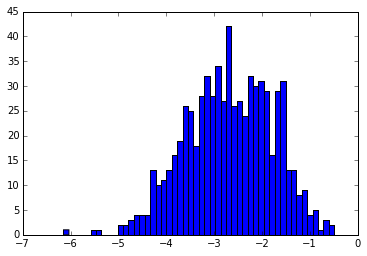

In [51]:
hist(clscores,50);

In [154]:
#save for enas
string = ''
times= O.Times()
cid = O.ClusterID()
for i in range(len(cid)):
    string += str(times[i])+" "+str(cid[i])+"\n"
    
with open("test.txt", "wt") as out_file:
    out_file.write(string)